In [1]:
# %pip install torch
# %pip install pymoo
# %pip install pywin32

In [2]:
print('hi')

hi


In [3]:
import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# Verify the path
print(f"Added to sys.path: {parent_dir}")

# Add it to sys.path
sys.path.append(parent_dir)

print(parent_dir)
from localityaware.module import *
from NSGA_nn.nsga import *
# from Vinyl_Distillation.VCDistillation import *

Added to sys.path: /Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen
/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen
['/Users/panwapromtep/miniforge3/envs/torch/lib/python312.zip', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/lib-dynload', '', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/site-packages', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen']


In [4]:
import pickle
with open('../NSGA_nn/results/vinyl/data_sim_12dim.pkl', 'rb') as f:
    out = pickle.load(f)
data_sim = out['data']

In [5]:
print(data_sim[0])

[3.00000000e+01 2.80000000e+01 5.63277935e-01 4.75067086e-01
 3.80000000e+01 2.90000000e+01 9.11560153e-01 9.02341635e-01
 2.96518058e-15 9.99872105e-01 3.36546905e+05 5.93528772e+03]


100


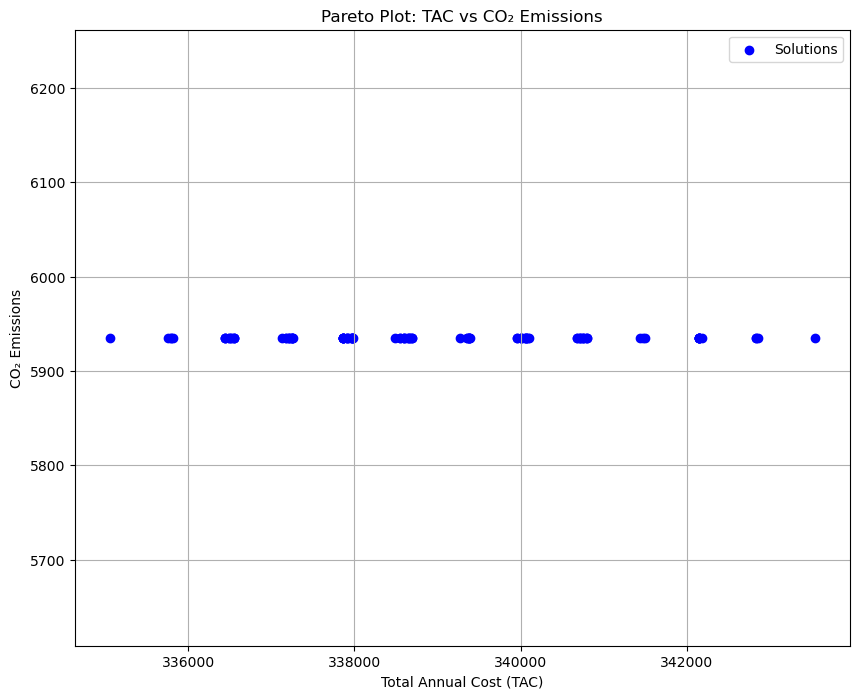

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# For demonstration purposes, assume you have an array of objectives
# with shape (N, 2) where each row is [TAC, CO₂ Emissions].
# Replace this with your actual data.
objectives = data_sim[:, -2:]  # Assuming the last two columns are the objectives
print(len(objectives))
plt.figure(figsize=(10, 8))
plt.scatter(objectives[:, 0], objectives[:, 1], color='blue', marker='o', label="Solutions")
plt.xlabel('Total Annual Cost (TAC)')
plt.ylabel('CO₂ Emissions')
plt.title('Pareto Plot: TAC vs CO₂ Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
print(len(data_sim))

# Instantiate the scaler with your provided ranges for 8-D inputs and 2-D outputs.
scaler = TorchMinMaxScaler(
    feature_range=(-1, 1), 
    max_vals=[36, 29, 1.5, 0.48, 42, 34, 1.5, 0.91],  # maximum for each of the 8 input parameters
    min_vals=[30, 2, 0.1, 0.46, 35, 2, 0.1, 0.89],       # minimum for each of the 8 inputs
    scale_y=True,
    min_y=[0, 0, 1e5, 1e4],   # minimum for the 4 outputs (e.g., acetyl purity, vinyl purity, TAC and CO₂)
    max_y=[1, 1, 1e6, 6e5]    # maximum for the 4 outputs
)

# Correct: use data_sim[:, :8] for inputs, and data_sim[:, 8:] for outputs.
data_sim_xscaled, data_sim_yscaled = scaler.transform(data_sim[:, :8], data_sim[:, 8:])

# Convert the PyTorch tensors to NumPy arrays.
data_sim_xscaled = data_sim_xscaled.detach().cpu().numpy()
data_sim_yscaled = data_sim_yscaled.detach().cpu().numpy()

# Check shapes for debugging:
print("Shape of scaled inputs:", data_sim_xscaled.shape)   # should be (N, 8)
print("Shape of scaled outputs:", data_sim_yscaled.shape)    # should be (N, 2)

# Recombine scaled inputs and outputs into one array with 10 columns (8 + 2).
data_sim_scaled = np.column_stack([data_sim_xscaled, data_sim_yscaled])
print("Shape of combined scaled data:", data_sim_scaled.shape)
print("First few rows of combined scaled data:\n", data_sim_scaled[:5])


# **Initialize Model & Dataset**
dataset = DynamicDataset(data_sim_scaled, num_inputs=8)
model = MLP(8, [50, 50, 20, 20, 50, 50], 4)

print("Dataset and model initialized.")

100
Shape of scaled inputs: (100, 8)
Shape of scaled outputs: (100, 4)
Shape of combined scaled data: (100, 12)
First few rows of combined scaled data:
 [[-1.          0.92592597 -0.33817434  0.5067078  -0.14285713  0.6875
   0.15937161  0.23416471 -1.          0.9997442  -0.4743402  -1.0137787 ]
 [ 1.          0.4074074   0.64249384 -0.01936901  1.          0.125
   0.5776391   0.6195376  -1.          0.9997442  -0.45880836 -1.0137787 ]
 [-0.3333333  -0.4814815   0.22173798 -0.879831   -0.14285713  0.
   0.9133011   0.25986624 -1.          0.9997442  -0.47124112 -1.0137787 ]
 [ 0.          0.5555556   0.33034706 -0.2924478   0.42857146 -0.9375
   0.22417295 -0.29043233 -1.          0.9997442  -0.4665137  -1.0137787 ]
 [-1.          0.5555556   0.16567564 -0.24803638  0.71428573  0.0625
   0.17841506 -0.10968167 -1.          0.9997442  -0.46956277 -1.0137787 ]]
Dataset and model initialized.


In [ ]:
from VCDistillation import VinylDistillationNNProblem

problem = VinylDistillationProbVinylDistillationNNProblemlem(model)

In [11]:
out = optimize_surr_nsga(model=model,
                   dataset=dataset,
                   assSim=None,
                   problem=problem,
                   lrs={'first':1e-3, 'others':1e-3},
                   epochs={'first':2000, 'others':200},
                   min_vals=scaler.min_x,
                   max_vals=scaler.max_x,
                   scaler=scaler,
                   device='cpu',
                   iter=1,
                   print_loss=True,
                   print_it_data=True,
                   pop_size=400,
                   n_gen = 5,
                   new_data_size=5,
                   batch_size=25
                   )

Iteration 0: Training surrogate model...
Epoch 0: Total Loss=0.0004
Epoch 50: Total Loss=0.0000
Epoch 100: Total Loss=0.0000
Epoch 150: Total Loss=0.0000
Epoch 200: Total Loss=0.0000
Epoch 250: Total Loss=0.0000
Epoch 300: Total Loss=0.0000
Epoch 350: Total Loss=0.0000
Epoch 400: Total Loss=0.0000
Epoch 450: Total Loss=0.0000
Epoch 500: Total Loss=0.0000
Epoch 550: Total Loss=0.0000
Epoch 600: Total Loss=0.0000
Epoch 650: Total Loss=0.0000
Epoch 700: Total Loss=0.0000
Epoch 750: Total Loss=0.0000
Epoch 800: Total Loss=0.0000
Epoch 850: Total Loss=0.0000
Epoch 900: Total Loss=0.0000
Epoch 950: Total Loss=0.0000
Epoch 1000: Total Loss=0.0000
Epoch 1050: Total Loss=0.0000
Epoch 1100: Total Loss=0.0000
Epoch 1150: Total Loss=0.0000
Epoch 1200: Total Loss=0.0000
Epoch 1250: Total Loss=0.0000
Epoch 1300: Total Loss=0.0000
Epoch 1350: Total Loss=0.0000
Epoch 1400: Total Loss=0.0000
Epoch 1450: Total Loss=0.0000
Epoch 1500: Total Loss=0.0000
Epoch 1550: Total Loss=0.0000
Epoch 1600: Total Loss

In [10]:
import os
import datetime
import pickle

print(os.getcwd())
# Get current notebook name manually (or hardcode it here)
notebook_name = "vinyl"  # or os.path.basename(__file__).replace(".py", "")

# Get timestamp
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct path: results/<notebook_name>/run_<timestamp>/
base_dir = os.path.join("../NSGA_nn/results", notebook_name)
save_dir = os.path.join(base_dir, f"run_{now}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

print(f"Results will be saved in: {save_dir}")

# Save out.pkl
out["data_gen_time"] = data_gen_time
out["total_original_assSim_calls"] = total_original_assSim_calls
with open(os.path.join(save_dir, "out.pkl"), "wb") as f:
    pickle.dump(out, f)

# Save scaler
with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Save dataset
with open(os.path.join(save_dir, "dataset.pkl"), "wb") as f:
    pickle.dump(dataset, f)

print(f"Saved all results in {save_dir}")


/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen/Vinyl_Distillation
../NSGA_nn/results/vinyl/run_2025-04-15_00-23-57
Results will be saved in: ../NSGA_nn/results/vinyl/run_2025-04-15_00-23-57


NameError: name 'data_gen_time' is not defined